In [1]:
from tensorflow import keras
from kdg.utils import generate_spirals as generate_data
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy.io import savemat, loadmat

from kdg.kdn import *

In [2]:
# kdn approx lin
kdn_kwargs = {
    "k": 1e-5,
    "polytope_compute_method": "all",
    "weighting_method": "lin",
    "T": 2,
    "c": 3,
    "verbose": False
}

In [3]:
# Define NN parameters
X_val, y_val = generate_data(500)
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=False)
fit_kwargs = {
    "epochs": 300,
    "batch_size": 64,
    "verbose": False,
    "validation_data": (X_val, keras.utils.to_categorical(y_val)),
    "callbacks": [callback],
}

In [4]:
# network architecture [10, 10, 10, 10, 2]
def getNN():
    network_base = keras.Sequential()
    initializer = keras.initializers.GlorotNormal(seed=0)
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer, input_shape=(2,)))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(10, activation="relu", kernel_initializer=initializer))
    network_base.add(keras.layers.Dense(units=2, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [18]:
# run the experiment
sample_size = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
n_test = 1000
reps = 1
accuracy_nn = []
class_0_num_polytopes = []
class_1_num_polytopes = []
reps_list = []
sample_list = []

df = {}

# run experiment
for sample in sample_size:
    print("Doing sample %d" % sample)
    for ii in range(reps):
        X, y = generate_data(sample)
        X_test, y_test = generate_data(n_test)

        # train Vanilla NN
        nn = getNN()
        nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

        accuracy_nn.append(
            np.mean(np.argmax(nn.predict(X_test), axis=1) == y_test)
        )
        
        # train KDN1
        model_kdn = kdn(nn, **kdn_kwargs)
        class_0_num_polytopes.append(
            len(np.unique(model_kdn._get_polytope_memberships(X[y==0])))
        )
        class_1_num_polytopes.append(
            len(np.unique(model_kdn._get_polytope_memberships(X[y==1])))
        )
        
        reps_list.append(ii)
        sample_list.append(sample)

df["class_0_numpoly"] = class_0_num_polytopes
df["class_1_numpoly"] = class_1_num_polytopes
df["reps_list"] = reps_list
df["sample_list"] = sample_list

Doing sample 10
Doing sample 50
Doing sample 100
Doing sample 500
Doing sample 1000
Doing sample 5000
Doing sample 10000
Doing sample 50000


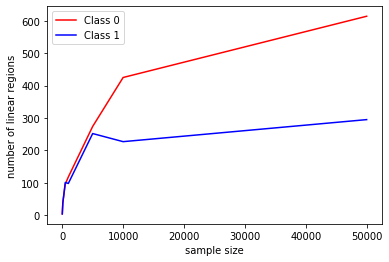

In [19]:
fig, ax = plt.subplots()
ax.plot(df["sample_list"], df["class_0_numpoly"], "r", label="Class 0")
ax.plot(df["sample_list"], df["class_1_numpoly"], "b", label="Class 1")
ax.set_xlabel("sample size")
ax.set_ylabel("number of linear regions")
ax.legend()